In [1]:
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
from utils import plot_images, train_valid_split
from metric import apk, mapk
import lightgbm as lgb

import faiss
import psutil
from lightfm import LightFM
from scipy import sparse
import catboost

In [2]:
dataset = '100'

transactions = pd.read_pickle(f"input/{dataset}/transactions_train.pkl")
users = pd.read_pickle(f"input/{dataset}/users.pkl")
items = pd.read_pickle(f"input/{dataset}/items.pkl")
transactions['day'] = (transactions['t_dat'].max() - transactions['t_dat']).dt.days


In [3]:
def create_candidates(transactions: pd.DataFrame, target_users: np.ndarray, week: int) -> pd.DataFrame:
    """
    transactions
        original transactions (user, item, week)
    target_users, week
        候補生成対象のユーザー
        weekで指定されている週の段階での情報のみから作られる
    """
    assert len(target_users) == len(set(target_users))

    def create_candidates_repurchase(
            prefix: str,
            transactions: pd.DataFrame,
            target_users: np.ndarray,
            week_start: int,
            week_end: int) -> pd.DataFrame:
        tr = transactions.query(
            "user in @target_users and @week_start <= week <= @week_end")[['user', 'item', 'week']].drop_duplicates(ignore_index=True)

        gr_week = tr.groupby(['user', 'item'])['week'].min().reset_index(name='week')
        gr_volume = tr.groupby(['user', 'item']).size().reset_index(name='volume')

        gr_week['week_rank'] = gr_week.groupby('user')['week'].rank()
        gr_volume['volume_rank'] = gr_volume.groupby('user')['volume'].rank()

        candidates = gr_week.merge(gr_volume, on=['user', 'item'])
        candidates = candidates[['user', 'item', 'week_rank', 'volume_rank']].rename(
            columns={'week_rank': f'{prefix}_week_rank', 'volume_rank': f'{prefix}_volume_rank'})
        return candidates

    def create_candidates_popular(
            prefix: str,
            transactions: pd.DataFrame,
            target_users: np.ndarray,
            week_start: int,
            week_end: int) -> pd.DataFrame:
        NUM_POPULAR_ITEMS = 12
        tr = transactions.query("@week_start <= week <= @week_end")[['user', 'item']].drop_duplicates(ignore_index=True)
        popular_items = tr['item'].value_counts().index.values[:NUM_POPULAR_ITEMS]
        popular_items = pd.DataFrame({
            'item': popular_items,
            'rank': range(NUM_POPULAR_ITEMS),
            'crossjoinkey': 1,
        })

        candidates = pd.DataFrame({
            'user': target_users,
            'crossjoinkey': 1,
        })

        candidates = candidates.merge(popular_items, on='crossjoinkey').drop('crossjoinkey', axis=1)
        candidates = candidates.rename(columns={'rank': f'{prefix}_rank'})
        return candidates

    def create_candidates_cooc(
            prefix: str,
            transactions: pd.DataFrame,
            week_start: int,
            week_end: int,
            base_candidates: pd.DataFrame) -> pd.DataFrame:
        tr = transactions.query("@week_start <= week == @week_end")[['user', 'item', 'week']].drop_duplicates(ignore_index=True)
        tr = tr.merge(tr.rename(columns={'item': 'item_with', 'week': 'week_with'}), on='user').query(
            "item != item_with and week <= week_with")[['item', 'item_with']].reset_index(drop=True)
        gr_sz = tr.groupby('item').size().reset_index(name='tot')
        gr_cnt = tr.groupby(['item', 'item_with']).size().reset_index(name='cnt')
        item2item = gr_cnt.merge(gr_sz, on='item')
        item2item['ratio'] = item2item['cnt'] / item2item['tot']
        item2item = item2item.query("ratio >= 0.030730").reset_index(drop=True)

        base_candidates_columns = [c for c in base_candidates.columns if c not in ['user', 'item', 'week']]
        replace = {c: f"{prefix}_{c}" for c in base_candidates_columns}
        candidates = base_candidates.merge(item2item, on='item').drop(
            ['item', 'cnt'], axis=1).rename(columns={'item_with': 'item'}).rename(columns=replace)
        candidates = candidates.rename(columns={'ratio': f'{prefix}_ratio', 'tot': f'{prefix}_tot'})
        return candidates

    def create_candidates_same_product_code(
            prefix: str,
            items: pd.DataFrame,
            base_candidates: pd.DataFrame) -> pd.DataFrame:
        item2item = items[['item', 'product_code']].merge(items[['item', 'product_code']].rename(
            {'item': 'item_with'}, axis=1), on='product_code')[['item', 'item_with']].query("item != item_with").reset_index(drop=True)

        base_candidates_columns = [c for c in base_candidates.columns if c not in ['user', 'item', 'week']]
        replace = {c: f"{prefix}_{c}" for c in base_candidates_columns}
        candidates = base_candidates.merge(
            item2item,
            on='item').drop(
            'item',
            axis=1).rename(
            columns={
                'item_with': 'item'}).rename(
                    columns=replace)
        return candidates

    candidates = [
        create_candidates_repurchase('repurchase', transactions, target_users, week, week + 40),
        create_candidates_popular('pop', transactions, target_users, week, week),
    ]
    candidates.append(create_candidates_cooc('cooc', transactions, week, week + 12, candidates[0]))
    candidates.append(create_candidates_same_product_code('same_product_code', items, candidates[0]))

    volumes = np.array([len(c) for c in candidates])
    print(volumes, volumes / np.sum(volumes))

    return pd.concat(candidates).reset_index(drop=True)


In [4]:
# valid: week=1
# train: week=2..1+num_train_weeks
num_train_weeks = 3
candidates = []
for week in range(1, 2+num_train_weeks):
    target_users = transactions[transactions['week'] == week]['user'].unique()
    candidates.append(create_candidates(transactions, target_users, week+1))

[1443705  827808 3449125 8777527] [0.09957846 0.05709743 0.2379008  0.60542331]
[1560164  864228 4908354 9468051] [0.0928625  0.0514397  0.29215007 0.56354773]
[1605657  909864 5007577 9934564] [0.09197434 0.05211832 0.28684122 0.56906612]
[ 1684869   963036  4950146 10432776] [0.0934438  0.05341053 0.27453793 0.57860774]


In [5]:
def merge_labels(candidates: pd.DataFrame, week: int) -> pd.DataFrame:
    """
    candidates
        (user, item, strategy, score)

    Return
    ------
    (user, item, y, ...)
    """
    labels = transactions[transactions['week'] == week][['user', 'item']].drop_duplicates(ignore_index=True)
    labels['y'] = 1
    original_positives = len(labels)
    labels = candidates.merge(labels, on=['user', 'item'], how='left')
    labels['y'] = labels['y'].fillna(0)
    remaining_positives = labels[['user', 'item', 'y']].drop_duplicates(ignore_index=True)['y'].sum()
    recall = remaining_positives / original_positives
    print(f"Recall: {recall}")
    return labels



In [6]:
for idx in range(len(candidates)):
    candidates[idx] = merge_labels(candidates[idx], 1+idx)


Recall: 0.09709069471477766
Recall: 0.09610372515466632
Recall: 0.0971546661962247
Recall: 0.09028811938613955


In [7]:
def get_query_group(df):
    def run_length_encoding(sequence):
        comp_seq_index, = np.concatenate(([True], sequence[1:] != sequence[:-1], [True])).nonzero()
        return sequence[comp_seq_index[:-1]], np.ediff1d(comp_seq_index)
    users = df['user'].values
    _, group = run_length_encoding(users)
    return list(group)

def drop_trivial_users(labels):
    """
    LightGBMのxendgcやlambdarankでは正例のみや負例のみのuserは学習に無意味なのと、メトリックの計算がおかしくなるので省く
    """
    bef = len(labels)
    df = labels[labels['user'].isin(labels[['user', 'y']].drop_duplicates().groupby(
        'user').size().reset_index(name='sz').query("sz==2").user)].reset_index(drop=True)
    aft = len(df)
    print(f"drop trivial queries: {bef} -> {aft}")
    return df


In [8]:
for idx in range(len(candidates)):
    candidates[idx]['week'] = 1+idx

valid_all = candidates[0].copy()

for idx in range(len(candidates)):
    candidates[idx] = drop_trivial_users(candidates[idx])


drop trivial queries: 14498165 -> 4658415
drop trivial queries: 16800797 -> 5564415
drop trivial queries: 17457662 -> 5808538
drop trivial queries: 18030827 -> 5726020


In [9]:
def attach_features(transactions: pd.DataFrame, users: pd.DataFrame, items: pd.DataFrame, candidates: pd.DataFrame, week: int) -> pd.DataFrame:
    """
    week: これを含めた以前の情報は使って良い
    """
    n_original = len(candidates)
    df = candidates.copy()

    # user static features
    user_features = ['FN', 'Active', 'age', 'club_member_status_idx', 'fashion_news_frequency_idx']
    df = df.merge(users[['user'] + user_features], on='user')

    # item static features
    item_features = [c for c in items.columns if c.endswith('idx')]
    df = df.merge(items[['item'] + item_features], on='item')

    # user dynamic features (transactions)
    num_weeks = 8
    week_end = week + num_weeks
    tmp = transactions.query("@week <= week < @week_end").groupby('user')[['price', 'sales_channel_id']].agg(['mean', 'std'])
    tmp.columns = ['user_' + '_'.join(a) for a in tmp.columns.to_flat_index()]
    df = df.merge(tmp, on='user', how='left')

    # item dynamic features (transactions)
    num_weeks = 8
    week_end = week + num_weeks
    tmp = transactions.query("@week <= week < @week_end").groupby('item')[['price', 'sales_channel_id']].agg(['mean', 'std'])
    tmp.columns = ['item_' + '_'.join(a) for a in tmp.columns.to_flat_index()]
    df = df.merge(tmp, on='item', how='left')

    # item dynamic features (user features)
    num_weeks = 8
    week_end = week + num_weeks
    tmp = transactions.query("@week <= week < @week_end").merge(users[['user', 'age']], on='user')
    tmp = tmp.groupby('item')['age'].agg(['mean', 'std'])
    tmp.columns = [f'age_{a}' for a in tmp.columns.to_flat_index()]
    df = df.merge(tmp, on='item', how='left')

    # item freshness features
    tmp = transactions.query("@week <= week").groupby('item')['week'].min().reset_index(name='item_week_min')
    tmp['item_week_min'] -= week
    df = df.merge(tmp, on='item', how='left')

    # item volume features
    num_weeks = 1
    week_end = week + num_weeks
    tmp = transactions.query("@week <= week < @week_end").groupby('item').size().reset_index(name='item_volume')
    df = df.merge(tmp, on='item', how='left')

    # # user freshness features
    # tmp = transactions.query("@week <= week").groupby('user')['week'].min().reset_index(name='user_week_min')
    # tmp['user_week_min'] -= week
    # df = df.merge(tmp, on='user', how='left')

    # # user volume features
    # num_weeks = 1
    # week_end = week + num_weeks
    # tmp = transactions.query("@week <= week < @week_end").groupby('user').size().reset_index(name='user_volume')
    # df = df.merge(tmp, on='user', how='left')

    # user-item freshness features
    tmp = transactions.query("@week <= week").groupby(['user', 'item'])['week'].min().reset_index(name='user_item_week_min')
    tmp['user_item_week_min'] -= week
    df = df.merge(tmp, on=['item', 'user'], how='left')

    # user-item volume features
    num_weeks = 1
    week_end = week + num_weeks
    tmp = transactions.query("@week <= week < @week_end").groupby(['user', 'item']).size().reset_index(name='user_item_volume')
    df = df.merge(tmp, on=['user', 'item'], how='left')

    assert len(df) == n_original
    return df


valid_all = attach_features(transactions, users, items, valid_all, 2)
for idx in range(len(candidates)):
    candidates[idx] = attach_features(transactions, users, items, candidates[idx], 2+idx)

In [10]:
for idx in range(len(candidates)):
    candidates[idx]['group'] = candidates[idx]['week'].astype(str) + '_' + candidates[idx]['user'].astype(str)
    candidates[idx] = candidates[idx].sort_values(by='group').reset_index(drop=True)

valid = candidates[0]

def concat_train(candidates, begin, num):
    train = pd.concat([candidates[idx] for idx in range(begin, begin+num)])
    return train

train = concat_train(candidates, 1, num_train_weeks)

In [11]:
feature_columns = [c for c in valid.columns if c not in ['y', 'week', 'group']]
print(feature_columns)


['user', 'item', 'repurchase_week_rank', 'repurchase_volume_rank', 'pop_rank', 'cooc_repurchase_week_rank', 'cooc_repurchase_volume_rank', 'cooc_tot', 'cooc_ratio', 'same_product_code_repurchase_week_rank', 'same_product_code_repurchase_volume_rank', 'FN', 'Active', 'age', 'club_member_status_idx', 'fashion_news_frequency_idx', 'product_type_no_idx', 'product_group_name_idx', 'graphical_appearance_no_idx', 'colour_group_code_idx', 'perceived_colour_value_id_idx', 'perceived_colour_master_id_idx', 'department_no_idx', 'index_code_idx', 'index_group_no_idx', 'section_no_idx', 'garment_group_no_idx', 'user_price_mean', 'user_price_std', 'user_sales_channel_id_mean', 'user_sales_channel_id_std', 'item_price_mean', 'item_price_std', 'item_sales_channel_id_mean', 'item_sales_channel_id_std', 'age_mean', 'age_std', 'item_week_min', 'item_volume', 'user_item_week_min', 'user_item_volume']


In [12]:
cat_feature_values = [c for c in feature_columns if c.endswith('idx')]
cat_features = [feature_columns.index(c) for c in cat_feature_values]
cat_features


[14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26]

In [13]:
train_pool = catboost.Pool(data=train[feature_columns], label=train['y'], group_id=train['group'], cat_features=cat_features)
valid_pool = catboost.Pool(data=valid[feature_columns], label=valid['y'], group_id=valid['group'], cat_features=cat_features)

In [14]:
params = {
    'loss_function': 'YetiRank',
    'use_best_model': True,
    'one_hot_max_size': 300,
}
model = catboost.CatBoost(params)
model.fit(train_pool, eval_set=valid_pool)

0:	test: 0.2534530	best: 0.2534530 (0)	total: 7.46s	remaining: 2h 4m 10s
1:	test: 0.2577483	best: 0.2577483 (1)	total: 14.8s	remaining: 2h 2m 43s
2:	test: 0.2620844	best: 0.2620844 (2)	total: 22.1s	remaining: 2h 2m 26s
3:	test: 0.2660234	best: 0.2660234 (3)	total: 29.4s	remaining: 2h 2m 9s
4:	test: 0.2772873	best: 0.2772873 (4)	total: 36.7s	remaining: 2h 1m 51s
5:	test: 0.2772831	best: 0.2772873 (4)	total: 44s	remaining: 2h 1m 37s
6:	test: 0.2773002	best: 0.2773002 (6)	total: 51.4s	remaining: 2h 1m 34s
7:	test: 0.2772071	best: 0.2773002 (6)	total: 58.7s	remaining: 2h 1m 20s
8:	test: 0.2817325	best: 0.2817325 (8)	total: 1m 6s	remaining: 2h 1m 13s
9:	test: 0.2816420	best: 0.2817325 (8)	total: 1m 13s	remaining: 2h 1m 6s
10:	test: 0.2814178	best: 0.2817325 (8)	total: 1m 20s	remaining: 2h 57s
11:	test: 0.2813221	best: 0.2817325 (8)	total: 1m 28s	remaining: 2h 48s
12:	test: 0.2891610	best: 0.2891610 (12)	total: 1m 35s	remaining: 2h 38s
13:	test: 0.2938936	best: 0.2938936 (13)	total: 1m 42s	r

In [15]:
# recent_items = transactions.query("2 <= week <= 4").item.unique()
# valid_all = valid_all.query("item in @recent_items")


In [16]:
valid_all['pred'] = model.predict(valid_all[feature_columns])
pred = valid_all.groupby(['user', 'item'])['pred'].max().reset_index()


In [17]:
pred = pred.sort_values(by=['user', 'pred'], ascending=False).reset_index(
    drop=True).groupby('user')['item'].apply(lambda x: list(x)[:12]).reset_index()
pred


,user,item
0,80,"[42129, 2865, 104045, 71107, 67522, 104072, 36..."
1,86,"[100228, 27905, 33868, 98606, 102472, 102473, ..."
2,107,"[2219, 61305, 61303, 61304, 13042, 53892, 8465..."
3,117,"[104045, 71107, 104072, 3091, 67522, 95217, 42..."
4,179,"[95216, 104986, 105180, 3510, 95217, 105179, 3..."
...,...,...
68979,1371868,"[93158, 37185, 93157, 93159, 17043, 104045, 69..."
68980,1371871,"[67522, 104045, 71107, 42626, 95217, 104072, 3..."
68981,1371879,"[103668, 103669, 103665, 103666, 98867, 103670..."
68982,1371937,"[59774, 59773, 59771, 71107, 67522, 59772, 104..."


In [18]:
gt = transactions[transactions['week'] == 1].groupby('user')['item'].apply(list).reset_index().rename(columns={'item': 'gt'})
merged = gt.merge(pred, on='user', how='left')
merged['item'] = merged['item'].fillna('').apply(list)
merged


,user,gt,item
0,80,[28967],"[42129, 2865, 104045, 71107, 67522, 104072, 36..."
1,86,[87371],"[100228, 27905, 33868, 98606, 102472, 102473, ..."
2,107,"[69711, 77256, 33872]","[2219, 61305, 61303, 61304, 13042, 53892, 8465..."
3,117,[97391],"[104045, 71107, 104072, 3091, 67522, 95217, 42..."
4,179,"[102397, 98409, 73, 95784, 103796, 105103, 103...","[95216, 104986, 105180, 3510, 95217, 105179, 3..."
...,...,...,...
68979,1371868,"[97531, 103424]","[93158, 37185, 93157, 93159, 17043, 104045, 69..."
68980,1371871,"[94310, 91533]","[67522, 104045, 71107, 42626, 95217, 104072, 3..."
68981,1371879,"[2118, 84994, 57078, 84991, 101099, 104036, 87...","[103668, 103669, 103665, 103666, 98867, 103670..."
68982,1371937,"[67261, 70640]","[59774, 59773, 59771, 71107, 67522, 59772, 104..."


In [19]:
mapk(merged['gt'], merged['item'])


0.030663502644505406

In [20]:
popular_items = transactions[transactions['week'] == 2]['item'].value_counts()[:12].index.tolist()
merged['item'] = merged['item'].apply(lambda x: x + popular_items)
mapk(merged['gt'], merged['item'])


0.030663502644505406

In [21]:
# assert False

submission

In [22]:
train = concat_train(candidates, 0, num_train_weeks)

In [23]:
train_pool = catboost.Pool(data=train[feature_columns], label=train['y'], group_id=train['group'], cat_features=cat_features)

params = {
    'iterations': model.get_best_iteration(),
    'loss_function': 'YetiRank',
    'one_hot_max_size': 300,
}
model = catboost.CatBoost(params)
model.fit(train_pool)

0:	total: 6.86s	remaining: 1h 53m 54s
1:	total: 13.9s	remaining: 1h 55m 17s
2:	total: 21s	remaining: 1h 56m 9s
3:	total: 27.9s	remaining: 1h 55m 15s
4:	total: 34.7s	remaining: 1h 54m 48s
5:	total: 41.6s	remaining: 1h 54m 26s
6:	total: 48.5s	remaining: 1h 54m 13s
7:	total: 55.4s	remaining: 1h 54m 12s
8:	total: 1m 2s	remaining: 1h 54m 4s
9:	total: 1m 9s	remaining: 1h 53m 56s
10:	total: 1m 16s	remaining: 1h 53m 47s
11:	total: 1m 23s	remaining: 1h 53m 37s
12:	total: 1m 29s	remaining: 1h 53m 29s
13:	total: 1m 36s	remaining: 1h 53m 11s
14:	total: 1m 43s	remaining: 1h 53m
15:	total: 1m 50s	remaining: 1h 52m 48s
16:	total: 1m 57s	remaining: 1h 52m 40s
17:	total: 2m 4s	remaining: 1h 52m 32s
18:	total: 2m 11s	remaining: 1h 52m 28s
19:	total: 2m 17s	remaining: 1h 52m 20s
20:	total: 2m 24s	remaining: 1h 52m 18s
21:	total: 2m 32s	remaining: 1h 52m 18s
22:	total: 2m 39s	remaining: 1h 52m 14s
23:	total: 2m 45s	remaining: 1h 52m 6s
24:	total: 2m 52s	remaining: 1h 52m 1s
25:	total: 2m 59s	remaining: 1h

In [24]:
all_users = users['user'].values
all_users

array([      0,       1,       2, ..., 1371977, 1371978, 1371979])

In [25]:
# to avoid OOM
preds = []

n_split_prediction = 10
n_chunk = (len(all_users) + n_split_prediction - 1)// n_split_prediction
for i in range(0, len(all_users), n_chunk):
    target_users = all_users[i:i+n_chunk]

    candidates = create_candidates(transactions, target_users, 1)
    candidates = attach_features(transactions, users, items, candidates, 1)

    candidates['pred'] = model.predict(candidates[feature_columns])
    pred = candidates.groupby(['user', 'item'])['pred'].max().reset_index()
    pred = pred.sort_values(by=['user', 'pred'], ascending=False).reset_index(drop=True).groupby('user')['item'].apply(lambda x: list(x)[:12]).reset_index()
    preds.append(pred)

pred = pd.concat(preds).reset_index(drop=True)
assert len(pred) == len(all_users)
assert np.array_equal(pred['user'].values, all_users)

[1025567 1646376 2587125 6816327] [0.08493031 0.13634138 0.21424765 0.56448067]
[1030106 1646376 2621757 6828428] [0.08494552 0.13576492 0.21619766 0.5630919 ]
[1008654 1646376 2552700 6744412] [0.08439107 0.13774736 0.21357678 0.5642848 ]
[1020567 1646376 2571872 6796394] [0.08479844 0.13679663 0.21369567 0.56470926]
[1024085 1646376 2596913 6828332] [0.08466517 0.13611244 0.2146971  0.5645253 ]
[1026309 1646376 2589859 6855059] [0.08469571 0.13586647 0.21372701 0.56571081]
[1013929 1646376 2562228 6770258] [0.08454487 0.13728047 0.21364735 0.56452731]
[1017427 1646376 2563217 6748762] [0.08495704 0.13747545 0.21403337 0.56353414]
[1012606 1646376 2562029 6724374] [0.08476964 0.13782528 0.21447856 0.56292652]
[1019855 1646376 2587814 6807427] [0.08455477 0.13649876 0.21455209 0.56439438]


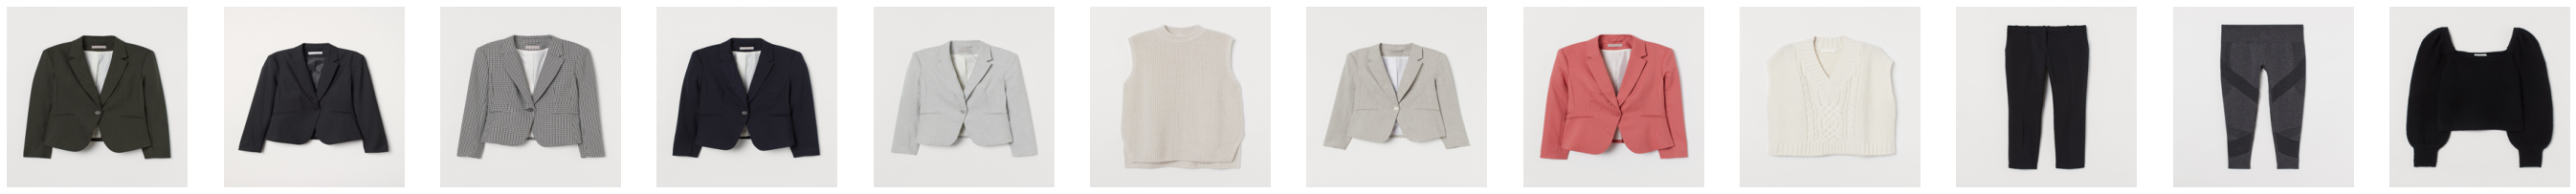

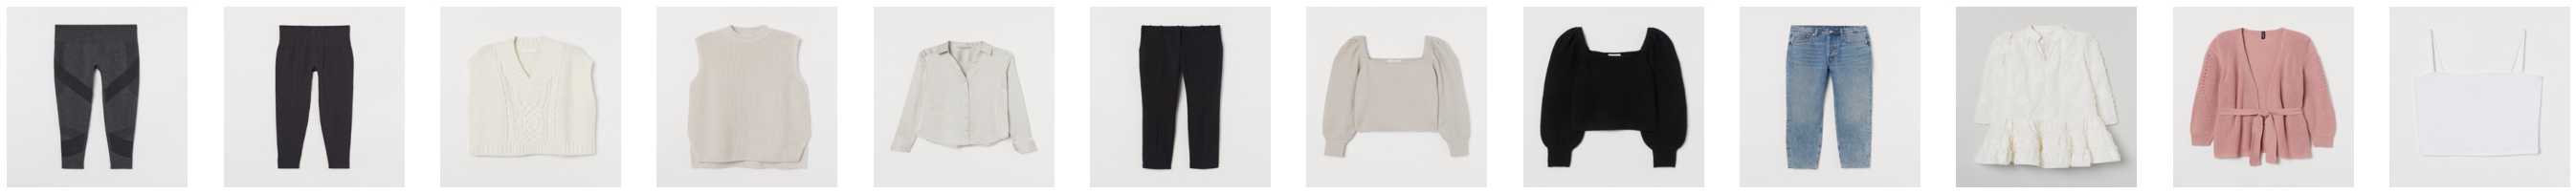

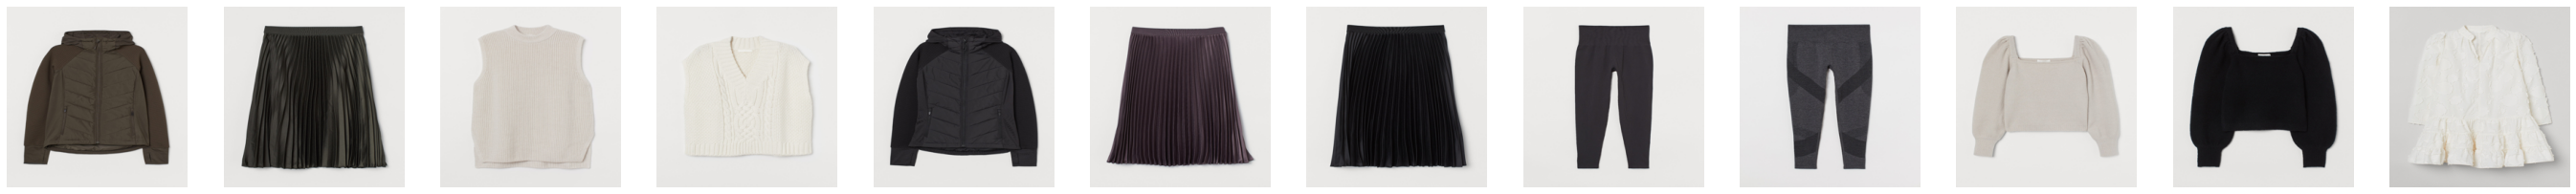

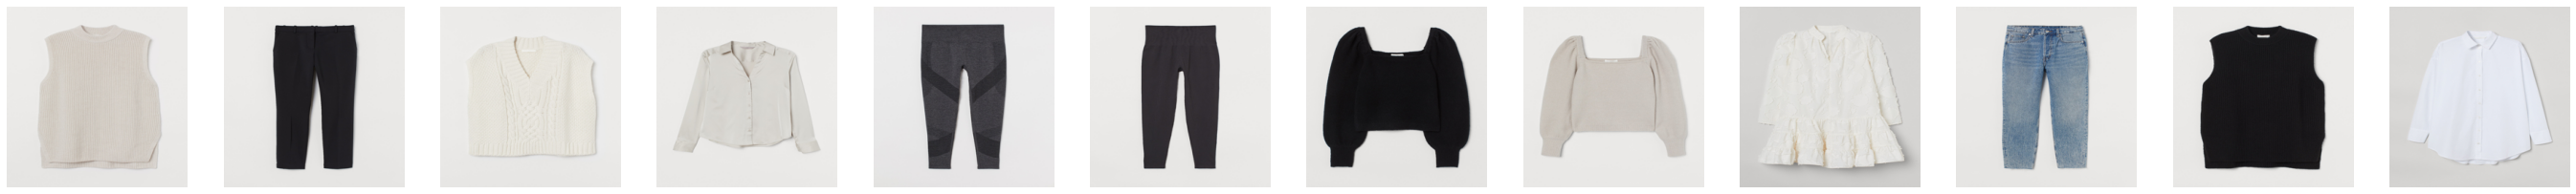

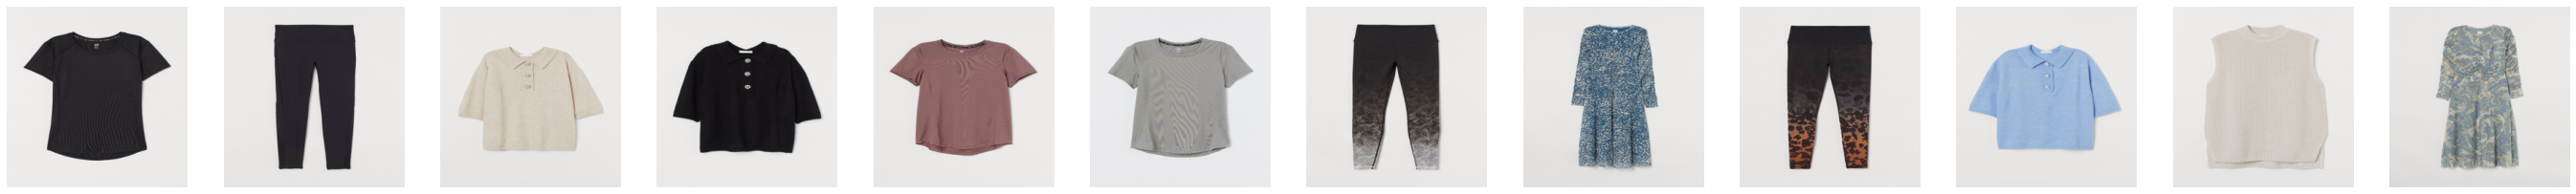

In [26]:
for i in range(5):
    plot_images(dataset, pred['item'][i])

In [27]:
mp_user = pd.read_pickle(f"input/{dataset}/mp_customer_id.pkl")
mp_item = pd.read_pickle(f"input/{dataset}/mp_article_id.pkl")

a_user = mp_user['val'].values
a_item = mp_item['val'].values

pred['customer_id'] = pred['user'].apply(lambda x: a_user[x])
pred['prediction'] = pred['item'].apply(lambda x: list(map(lambda y: a_item[y], x)))

pred['prediction'] = pred['prediction'].apply(lambda x: ' '.join(map(str, x)))

submission = pred[['customer_id', 'prediction']]
submission

,customer_id,prediction
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,0568601043 0568601006 0568601044 0568601007 05...
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,0918292001 0866731001 0918522001 0924243001 07...
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0794321007 0851400020 0924243001 0918522001 07...
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,0924243001 0751471001 0918522001 0762846027 09...
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,0791587001 0730683050 0896152001 0896152002 07...
...,...,...
1371975,ffffbbf78b6eaac697a8a5dfbfd2bfa8113ee5b403e474...,0791587001 0557599022 0804992014 0791587015 08...
1371976,ffffcd5046a6143d29a04fb8c424ce494a76e5cdf4fab5...,0762846026 0762846027 0762846031 0762846006 07...
1371977,ffffcf35913a0bee60e8741cb2b4e78b8a98ee5ff2e6a1...,0762846027 0762846026 0762846006 0706016002 07...
1371978,ffffd7744cebcf3aca44ae7049d2a94b87074c3d4ffe38...,0714790020 0821395005 0714790028 0918522001 08...


In [28]:
submission.to_csv('submission.csv', index=False)